In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os


In [2]:
path = "./shanghai/"

images = []
image_filenames = os.listdir(path)

for image_filename in image_filenames:
    images.append(cv2.cvtColor(cv2.imread(path + image_filename), cv2.COLOR_BGR2RGB))

images = images[::-1]

(683, 1024, 3)

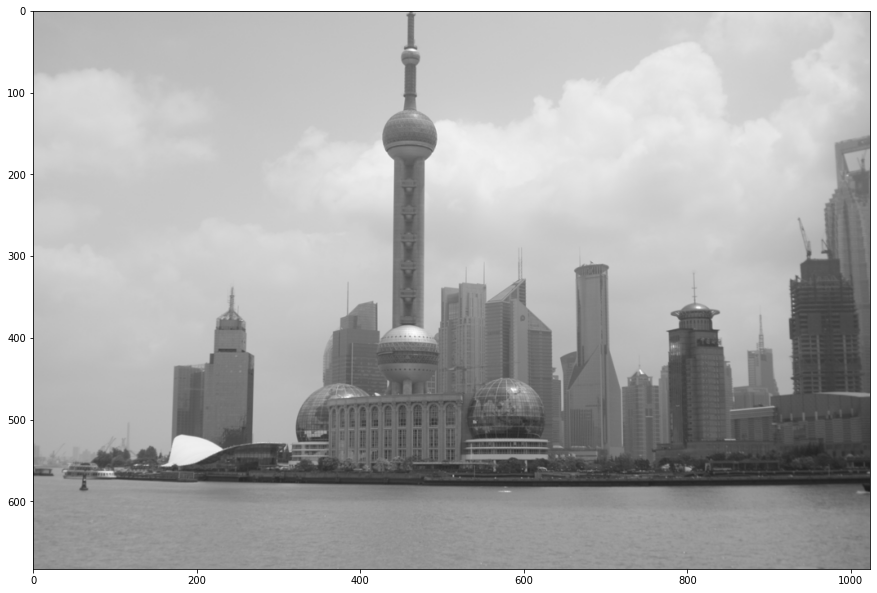

In [3]:
first_view = images[1]

plt.figure(figsize=(15, 15))
plt.imshow(first_view)

first_view.shape

(683, 1024, 3)

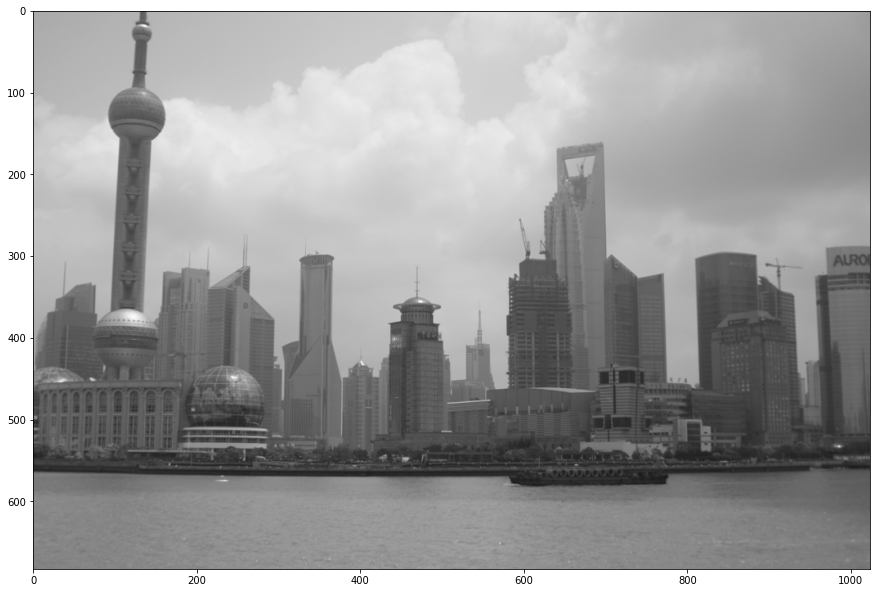

In [4]:
second_view = images[0]

plt.figure(figsize=(15, 15))
plt.imshow(second_view, cmap="gray")

second_view.shape

In [5]:
# function to detect the features by finding key points and descriptors from the image
def detector(image):
    # creating SIFT detector
    sift = cv2.SIFT_create()

    # finding key points and descriptors of both images using detectAndCompute() function
    key_points, descriptors = sift.detectAndCompute(image, None)

    return key_points, descriptors

In [6]:
def DrawKeypoints(image, key_points):
    _features_img = np.zeros(shape=image.shape)

    _features_img = cv2.drawKeypoints(image, key_points, _features_img)

    return _features_img

In [7]:
# function to find best detected features using brute force
# matcher and match them according to there humming distance
def BF_FeatureMatcher(des1, des2, threshold=0.35):
    # brute_force = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    # _matches = brute_force.match(des1, des2)

    brute_force = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_BRUTEFORCE)
    _matches = brute_force.knnMatch(des1, des2, k=2)

    # Sort them in the order of their distance.
    good = []
    for m, n in _matches:
        if m.distance < threshold * n.distance:
            good.append(m)

    good = sorted(good, key=lambda x: x.distance)

    return good


In [8]:
def Flann_FeatureMatcher(des1, des2, threshold=0.35):
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    # matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    _matches = flann.knnMatch(des1, des2, k=2)

    good = []
    for m, n in _matches:
        if m.distance < threshold * n.distance:
            good.append(m)

    good = sorted(good, key=lambda x: x.distance)

    return good

(4.013131141662598, 561.7183227539062)

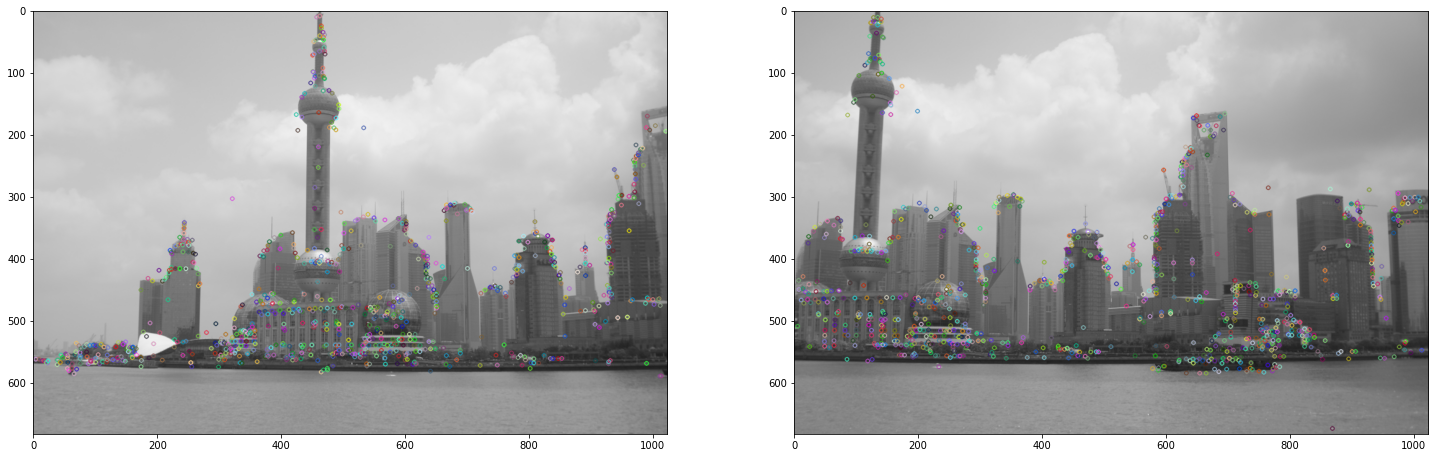

In [9]:
features_1, descriptor_1 = detector(first_view)
features_2, descriptor_2 = detector(second_view)

features_img_1 = DrawKeypoints(first_view, features_1)
features_img_2 = DrawKeypoints(second_view, features_2)

_, ax = plt.subplots(nrows=1, ncols=2, figsize=(25, 25))
ax = ax.flatten()
ax[0].imshow(features_img_1, cmap="gray")
ax[1].imshow(features_img_2, cmap="gray")

features_1[0].pt  # cv2.KeyPoint

291

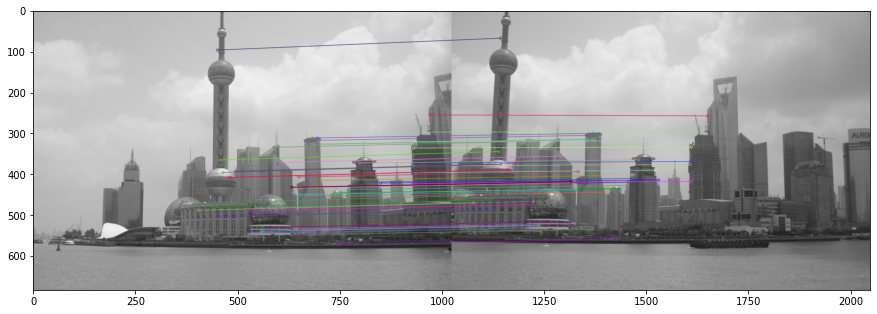

In [10]:
matches = Flann_FeatureMatcher(descriptor_1, descriptor_2, threshold=0.45)

output_image = cv2.drawMatches(first_view, features_1, second_view, features_2, matches[0:50], None, flags=2)

plt.figure(figsize=(15, 15))
plt.imshow(output_image, cmap="gray")

#matches[0].queryIdx  # cv2.DMatch
len(matches)

In [11]:
def getCorrespondences(_matches, _features_1, _features_2):
    src_pts = np.float32([_features_1[match.queryIdx].pt for match in _matches]).reshape(-1, 1, 2)

    dst_pts = np.float32([_features_2[match.trainIdx].pt for match in _matches]).reshape(-1, 1, 2)

    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    return H


In [12]:
def findHomography_scratch(src_pts, dst_pts):
    # define similarity transformation
    # no rotation, scaling using sdv and setting centroid as origin

    mean = np.mean(src_pts, axis=0)
    mx = mean[0]
    my = mean[1]
    distances = 0
    for i in range(src_pts.shape[0]):
        distances += np.sqrt((src_pts[i][0] - mx) ** 2 + (src_pts[i][1] - my) ** 2)

    s = np.sqrt(2.0) * src_pts.shape[0] / distances

    T = np.array([[s, 0, -mx * s],
                  [0, s, -my * s],
                  [0, 0, 1]])

    # convert to homogenous coordinates
    src_pts = np.c_[src_pts, np.ones(src_pts.shape[0])]
    # apply the transformation
    src_pts = np.dot(T, src_pts.T).T

    mean = np.mean(dst_pts, axis=0)
    mx = mean[0]
    my = mean[1]
    distances = 0
    for i in range(dst_pts.shape[0]):
        distances += np.sqrt((dst_pts[i][0] - mx) ** 2 + (dst_pts[i][1] - my) ** 2)

    s = np.sqrt(2.0) * dst_pts.shape[0] / distances

    T_prime = np.array([[s, 0, -mx * s],
                        [0, s, -my * s],
                        [0, 0, 1]])

    # convert to homogenous coordinates
    dst_pts = np.c_[dst_pts, np.ones(dst_pts.shape[0])]
    # apply the transformation
    dst_pts = np.dot(T_prime, dst_pts.T).T

    A = []
    for correspondence in range(src_pts.shape[0]):
        x, y = src_pts[correspondence][0], src_pts[correspondence][1]
        x_dash, y_dash = dst_pts[correspondence][0], dst_pts[correspondence][1]

        A.append([-x, -y, -1, 0, 0, 0, x * x_dash, y * x_dash, x_dash])
        A.append([0, 0, 0, -x, -y, -1, x * y_dash, y * y_dash, y_dash])

    A = np.asarray(A)

    U, S, V = np.linalg.svd(A)

    H_tilde = V[-1, :].reshape(3, 3)

    # denormalize to obtain homography (H) using the transformations and generalized pseudo-inverse
    H = np.dot(np.linalg.inv(T_prime), np.dot(H_tilde, T))

    H /= H[2, 2]

    return H

In [13]:
def getCorrespondences_scratch(_matches, _features_1, _features_2):
    src_pts = np.float32([_features_1[match.queryIdx].pt for match in _matches]).squeeze()

    dst_pts = np.float32([_features_2[match.trainIdx].pt for match in _matches]).squeeze()

    H = findHomography_scratch(src_pts, dst_pts)

    return H


In [14]:
def trim(frame):
    #crop top
    if not np.sum(frame[0]):
        return trim(frame[1:])
    #crop bottom
    elif not np.sum(frame[-1]):
        return trim(frame[:-2])
    #crop left
    elif not np.sum(frame[:, 0]):
        return trim(frame[:, 1:])
    #crop right
    elif not np.sum(frame[:, -1]):
        return trim(frame[:, :-2])
    return frame

In [15]:
def overlay(_H, _base, _view):
    base_width = _base.shape[1]
    base_height = _base.shape[0]

    view_width = _view.shape[1]
    view_height = _view.shape[0]

    total_width = base_width + view_width
    total_height = base_height + view_height

    output = np.zeros((total_height, total_width, 3), dtype=np.uint8)

    #####################################################################

    # FORWARD WARPING
    for y_old in range(base_height):
        for x_old in range(base_width):

            point = np.dot(_H, (x_old, y_old, 1))

            x_new = int(round(point[0] / point[2]))
            y_new = int(round(point[1] / point[2]))

            try:
                if x_new >= 0 and y_new >= 0:
                    output[y_new, x_new] = _base[y_old, x_old]
            except:
                pass

    #####################################################################

    warping = output.copy()

    output[0:view_height, 0:view_width] = _view

    #####################################################################

    # INVERSE WARPING

    # define a mask to figure out the area to apply inverse warping
    mask = np.zeros(output.shape[0:2], dtype=np.uint8)

    corners_base = np.float32([[0, 0], [0, base_height], [base_width, base_height], [base_width, 0]]).reshape(-1, 1, 2)
    corners_base_warped = cv2.perspectiveTransform(corners_base, _H)
    corners_base_warped[corners_base_warped < 0] = 0

    cv2.fillConvexPoly(mask, corners_base_warped.astype(int), 1)

    mask[0:view_height, 0:view_width] = 0

    # plt.figure(figsize=(15, 15))
    # plt.imshow(mask, cmap='gray')

    H_inv = np.linalg.inv(_H)

    for y in range(total_height):
        for x in range(total_width):

            if mask[y,x] == 1:
                try:
                    if output[y, x].all() == 0:
                        point = np.dot(H_inv, (x, y, 1))

                        x_old = point[0] / point[2]
                        y_old = point[1] / point[2]

                        x_right = np.ceil(x_old).astype(int)
                        x_left = np.floor(x_old).astype(int)

                        y_up = np.floor(y_old).astype(int)
                        y_down = np.ceil(y_old).astype(int)

                        x_fr = x_old - x_left
                        y_fr = y_old - y_up

                        x_diff = np.array([x_fr, 1 - x_fr]).reshape(1, 2)
                        y_diff = np.array([1 - y_fr, y_fr]).reshape(2, 1)

                        for channel in range(3):
                            p1 = _base[y_up, x_left, channel]
                            p2 = _base[y_down, x_left, channel]
                            p3 = _base[y_up, x_right, channel]
                            p4 = _base[y_down, x_right, channel]

                            T = np.array([p1, p3, p2, p4]).reshape(2, 2)
                            new_value = np.dot(np.dot(x_diff, T), y_diff)

                            output[y, x, channel] = new_value.squeeze()
                except:
                    pass


    return trim(output), warping

In [16]:
def stitch(view1, view2):
    total_matches = 0
    min_threshold = 0.1
    min_matches = 50

    _features_1, _descriptor_1 = detector(view1)
    _features_2, _descriptor_2 = detector(view2)

    # print('matching ...')
    while total_matches < min_matches:
        _matches = Flann_FeatureMatcher(_descriptor_1, _descriptor_2, min_threshold)
        total_matches = len(_matches)

        # print(total_matches)
        # print(min_threshold)

        if min_threshold > 0.6:
            min_matches -= 5
        else:
            min_threshold += 0.01

    _Homography_matrix = getCorrespondences(_matches, _features_1, _features_2)

    _output_image, _warped_view = overlay(_Homography_matrix, view1, view2)

    return _output_image, _warped_view


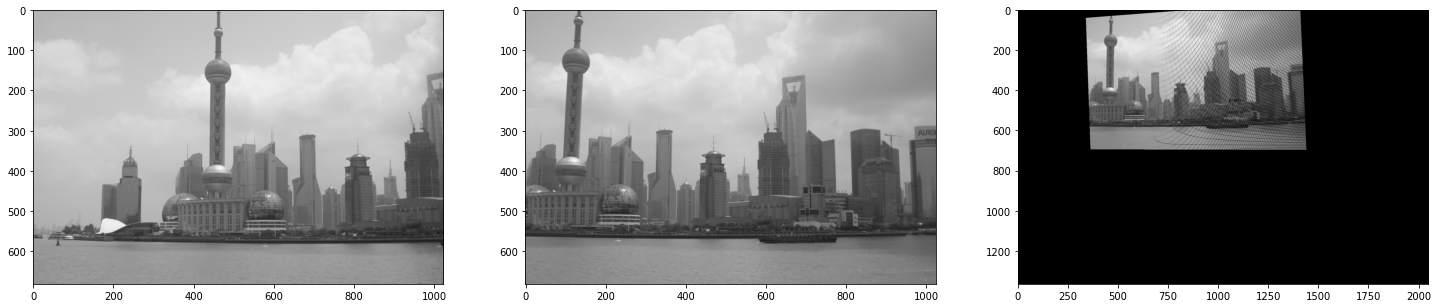

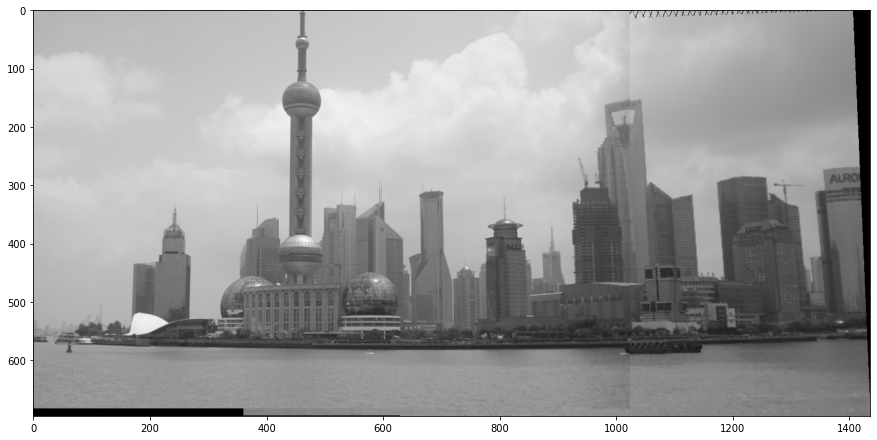

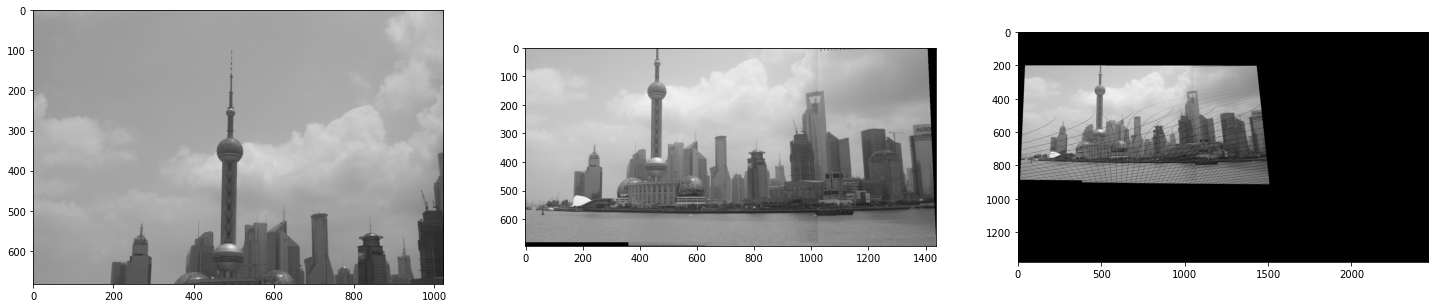

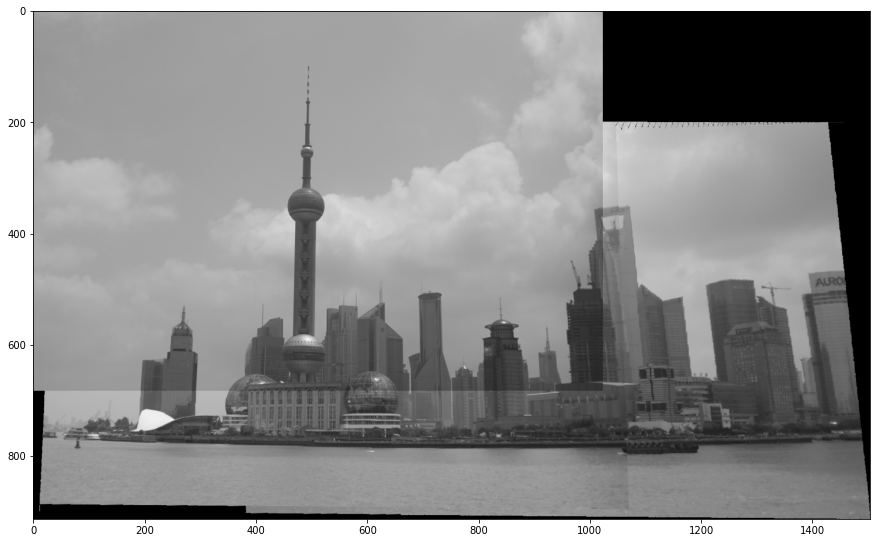

In [17]:
output_image = []

for i in range(0, len(images), 2):
    output_image, warped_view = stitch(images[i], images[i + 1])

    _, ax = plt.subplots(nrows=1, ncols=3, figsize=(25, 25))
    ax = ax.flatten()
    ax[0].imshow(images[i + 1])
    ax[1].imshow(images[i])
    ax[2].imshow(warped_view)

    plt.figure(figsize=(15, 15))
    plt.imshow(output_image)

    images.insert(i + 2, output_image)


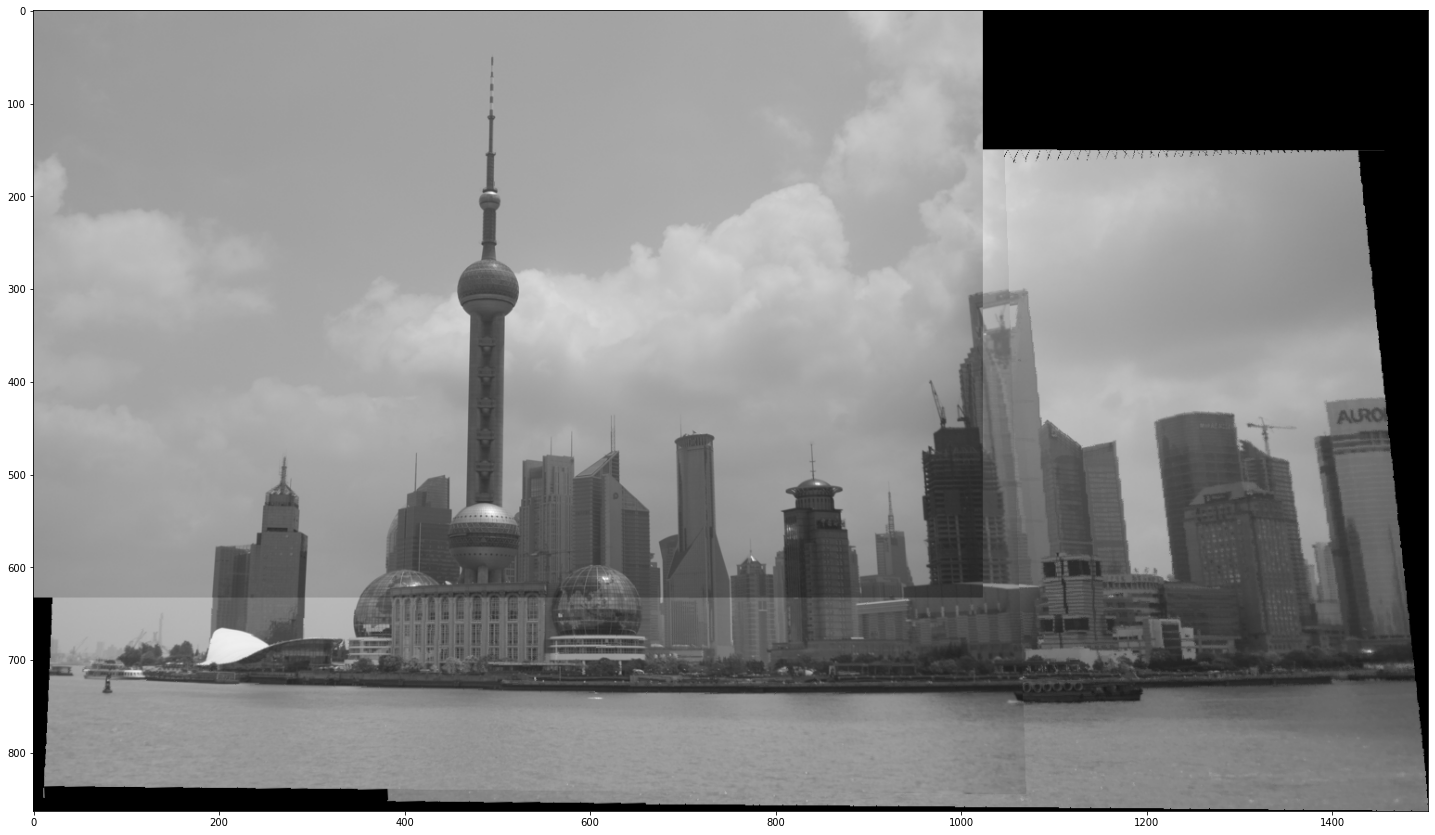

In [18]:
output_image = output_image[50:1360,0:5120]

plt.figure(figsize=(25, 25))
plt.imshow(output_image)

In [19]:
# cv2.imwrite('city_panorama.png', cv2.cvtColor(output_image[0:1360,0:5120], cv2.COLOR_RGB2BGR))